In [26]:
import numpy as np
import random

import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import  accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import os
import matplotlib.pyplot as plt
import shutil
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2,f_classif
from sklearn import preprocessing
import math
from sklearn.metrics import fbeta_score
from numpy import arange
from sklearn.metrics import balanced_accuracy_score

In [27]:
metric_to_optimize = 'MCC'

In [28]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=RuntimeWarning)

In [29]:
def print_and_summarize_best_model(results,ml_results,best_models):
    ml_results = pd.concat([ml_results, results],sort=True)
    best_model_index = np.argmax(np.array(results[metric_to_optimize]))
    best_model = results.iloc[best_model_index]
    best_models = pd.concat([best_models, pd.DataFrame(best_model).transpose()],sort = True)
    
    return ml_results,best_models,best_model_index

In [30]:
def init_metrics():
    '''
    initialize the (empty) metrics structures
    :return: metrics_results
    '''
    metrics_results = {'FNR': None, 'FPR': None, 'MCC':None, 'ACC': None, 'F1score': None,'F2score': None}
    metrics_results['FNR'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['FPR'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['MCC'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['ACC'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['F1score'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['F2score'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    return metrics_results

def init_best_models():
    best_models = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    return best_models

def init_ml_results():
    ml_results = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    return ml_results

In [31]:
def metrics_calculation_as_binary(all_y,all_predictions):
    cm = confusion_matrix(all_y,all_predictions,labels = ['Clog','Control','Leak'])
    TP = cm[0,0]+cm[0,2]+cm[2,2]+cm[2,0] # clog or leak classified correctly
    FN = cm[0,1]+cm[2,1] #clog or leak classified as control
    FP = cm[1,0]+cm[1,2] #control classified as leak or clog
    TN = cm[1,1] #control  classified correctly
    
    FNR = FN/(FN+TP)
    FPR = FP/(FP+TN)

    Recall =TP/(TP+FN)
    Precision=TP/(TP+FP)
#     Accuracybinary = (TP+TN)/(TP+TN+FN+FP)
    F1_Binary = 2*(Recall*Precision)/(Recall+Precision)
    F2_Binary = ((1 + 2**2) * Precision * Recall) / (2**2 * Precision + Recall)
    return FNR,FPR,F1_Binary,F2_Binary

In [32]:
def calculate_metrics(classifier_name,y_test,y_prediction_old,metrics_results):
    '''
    calculate each metric for evaluation
    :param classifier_name: name of classifier used (svm, NB, etc)
    :param y_test:
    :param y_prediction:
    :param metrics_results:
    :return:
    '''
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    from sklearn.metrics import matthews_corrcoef
    y_test = y_test.astype('category').to_numpy()
    y_prediction = np.copy(y_prediction_old)
    y_prediction[(y_test == 'Clog') & (y_prediction_old=="Leak")]='Clog' #CLOG CLASIFIED AS LEAK
    y_prediction[(y_test == 'Leak') & (y_prediction_old=="Clog")]='Leak'# LEAK CLASSIFIED AS CLOG
    
    cnf_matrix = confusion_matrix(y_test, y_prediction,
                                         labels=["Leak", "Clog", "Control"])
#     import seaborn as sns
#     plt.figure()
#     sns.heatmap(cnf_matrix, annot=True)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)

    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Fall out or false positive rate
    FPR_mal = (FP/(FP+TN))

    # False negative rate
    FNR_mal = (FN/(TP+FN))

    y_prediction_binary = np.zeros(y_test.size)
    y_prediction_binary[(y_prediction_old=="Clog") | (y_prediction_old=="Leak")]=1 #CLOG CLASIFIED AS LEAK
    y_prediction_binary[y_prediction_old == "Control"]=0
    
    y_test_binary =np.zeros(y_test.size)
    y_test_binary[(y_test == "Clog")| (y_test=="Leak")]=1
    y_test_binary[y_test == "Control"]=0
    

    TN, FP, FN, TP = confusion_matrix(y_test_binary, y_prediction_binary).ravel()

    FPR  = FP / (FP + TN)
    FNR = FN / (FN + TP)

    F1_Binary = fbeta_score(y_test_binary, y_prediction_binary, beta=1)
    F2_Binary = fbeta_score(y_test_binary, y_prediction_binary, beta=2)
    MCC = matthews_corrcoef(y_test_binary, y_prediction_binary)
    Accuracy = accuracy_score(y_test_binary, y_prediction_binary)
    balanced_ACC = balanced_accuracy_score(y_test_binary, y_prediction_binary)
    
#     FNR,FPR,F1_Binary,F2_Binary = metrics_calculation_as_binary(y_test, y_prediction)#As Binary
    
    MCC_multiclass = matthews_corrcoef(y_test, y_prediction)
#     Accuracy = accuracy_score(y_test, y_prediction)
    metrics_results['FNR'][classifier_name] = {'FNR':FNR,'Leak':FNR_mal[0],'Clog':FNR_mal[1],'MCC_multiclass':MCC_multiclass}
    metrics_results['FPR'][classifier_name] = {'FPR':FPR,'Leak':FPR_mal[0],'Clog':FPR_mal[1],'balanced_ACC':balanced_ACC}
    metrics_results['MCC'][classifier_name] = MCC
    metrics_results['ACC'][classifier_name] = Accuracy
    metrics_results['F1score'][classifier_name] = F1_Binary
    metrics_results['F2score'][classifier_name] = F2_Binary
    return metrics_results

In [33]:
def save_folds_for_best_model(model_index,folds,MCC_results,F1score_results,F2score_results,FNR_results):
    print(model_index)
    folder_path = 'C:\\Users\\noy\\Desktop\\תזה\\Results\\Lavi_secend_best_model_'
    balanced_ACC_results = pd.DataFrame(d['balanced_ACC'] for d in FNR_results).values.ravel()
    Al = 'KNN_73_multiclass'

    best_mudel_res= pd.DataFrame(data={'Algorithm':Al,
                                          'Fold_number':folds,
                                          'MCC': MCC_results,
                                           'balanced_ACC':balanced_ACC_results,
                                          'F1score': F1score_results,
                                          'F2score': F2score_results})
    best_mudel_res =best_mudel_res.set_index('Fold_number')
    best_mudel_res.to_csv(folder_path+Al+'_folds_results.csv')
    print('Created')
    return

In [34]:
def CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params):
    folds,FNR_results, FPR_results, MCC_results, ACC_results,F1score_results,F2score_results = [],[],[],[],[],[],[]                      
#     if(model_index==73):
    random.seed(10)
    fold=1
    skf = RepeatedStratifiedKFold(n_splits=5,n_repeats=5, random_state=12)
    # K_folds:
    for train_index, test_index in skf.split(data, data_labels):
        x_train_fold, x_test_fold = data.iloc[train_index], data.iloc[test_index]
        y_train_fold, y_test_fold = data_labels.iloc[train_index], data_labels.iloc[test_index]
        if (Algorithm not in ['RF','DT']):
            if (Algorithm in('Naive Bayes','svm_linear')):
                scaler = MinMaxScaler()
            else:
                scaler = StandardScaler()
            x_train_fold = scaler.fit_transform(x_train_fold)
            x_test_fold = scaler.fit_transform(x_test_fold)
        classifier.fit(x_train_fold, y_train_fold.values.ravel())
        y_prediction = classifier.predict(x_test_fold)
        metrics_results = calculate_metrics(Algorithm,y_test_fold,y_prediction,metrics_results)
        FNR_results.append(metrics_results['FNR'][Algorithm])
        FPR_results.append(metrics_results['FPR'][Algorithm])
        MCC_results.append(metrics_results['MCC'][Algorithm])
        ACC_results.append(metrics_results['ACC'][Algorithm])
        F1score_results.append(metrics_results['F1score'][Algorithm])
        F2score_results.append(metrics_results['F2score'][Algorithm])
        folds.append(fold)
        fold =fold+1
#         save_folds_for_best_model(model_index,folds,MCC_results,F1score_results,F2score_results,FPR_results)

        results_summary = results_summary.append({'Algorithm':Algorithm,
                                                  'model_index':model_index,
                                                  'parameters':params,
                                                  'FNR': {'FNR':sum(d['FNR'] for d in FNR_results) / len(FNR_results),
                                                         'FNR_Leak':sum(d['Leak'] for d in FNR_results) / len(FNR_results),
                                                         'FNR_Clog':sum(d['Clog'] for d in FNR_results) / len(FNR_results),
                                                         'MCC_multiclass':sum(d['MCC_multiclass'] for d in FNR_results) / len(FNR_results)}, #np.mean(FNR_results),
                                                  'FPR': {'FPR':sum(d['FPR'] for d in FPR_results) / len(FPR_results),
                                                         'FPR_Leak':sum(d['Leak'] for d in FPR_results) / len(FPR_results),
                                                         'FPR_Clog':sum(d['Clog'] for d in FPR_results) / len(FPR_results),
                                                          'balanced_ACC':sum(d['balanced_ACC'] for d in FPR_results) / len(FPR_results)},
                                                  'MCC': np.mean(MCC_results),
                                                  'ACC': np.mean(ACC_results),
                                                  'F1score': np.mean(F1score_results),
                                                  'F2score': np.mean(F2score_results)},
                                                 ignore_index=True)
    return results_summary

In [35]:
def train_test_CV_RandomForest(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'RF' 
    
    n_estimators = [200, 500]               # number of trees in the foreset
    max_depth = [5, 8, 10, 20]              # max number of levels in each decision tree
    criterion = ['gini', 'entropy']
    min_samples_split = [2, 5, 10, 15,20]   # min number of data points placed in a node before the node is split, used to control over-fitting
    bootstrap = [True, False]
    for n in n_estimators:
        for max in max_depth:
            for c in criterion:
                for min_sample in min_samples_split:
                    for b in bootstrap:
                        classifier = RandomForestClassifier(random_state=12,class_weight='balanced', n_estimators=n,
                                                            max_depth=max, criterion=c,min_samples_split=min_sample,bootstrap=b)  # class_weight: misclassifying the rare class is punished harsher.
                        params = {"n_estimators": n,"criterion": c,"min_samples_split":min_sample,"bootstrap":b,'max_depth':max}
                        results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)
                        model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results

In [36]:
def train_test_CV_svm_linear(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'svm_linear'
    kernel = 'linear'
    cs = [0.1, 1, 10, 100]
    for c in cs:
        classifier = svm.SVC(probability=True,kernel=kernel,C=c,max_iter=100000)
        params = {"kernel": kernel,"C": c}
        results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)
        model_index+=1

    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [37]:
def train_test_CV_svm_rbf(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'svm_rbf'
    kernel =  'rbf'
    cs = [0.1, 1, 10, 100]
    gammas = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4]
    for c in cs:
        for gamma in gammas:
            classifier = svm.SVC(probability=True,kernel=kernel,C=c,gamma=gamma,max_iter=100000)
            params = {"kernel": kernel,"C": c,'gamma':gamma}
            results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

            model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [38]:
def train_test_CV_svm_poly(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'svm_poly'

    kernel = 'poly'
    cs = [0.1, 1, 10, 100]
    gammas = [0.0001, 0.001, 0.01, 0.1, 1]
    degrees = [2,3,4,5]
    for c in cs:
        for gamma in gammas:
            for degree in degrees:
                classifier = svm.SVC(probability=True,kernel=kernel,C=c,gamma=gamma,degree=degree,max_iter=100000)
                params = {"kernel": kernel,"C": c,'gamma':gamma,'degree':degree}
                results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

                model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [39]:
def train_test_CV_DecisionTree(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'DT'
    
    criterion = ["gini", "entropy"]
    splitter = ["best", "random"]
    min_samples_split = [2, 5, 10, 15,20]  # min number of data points placed in a node before the node is split, used to control over-fitting
    for c in criterion:
        for s in splitter:
            for min_split in min_samples_split:
                classifier = tree.DecisionTreeClassifier(criterion=c,splitter=s,min_samples_split=min_split)
                params = {"criterion": c,"splitter": s,'min_samples_split':min_split}
                results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

                model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [40]:
def train_test_CV_NaiveBayes(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'NB'
    Algorithm = 'Naive Bayes'
    NB_Classifiers = [GaussianNB(), MultinomialNB()]
    # CategoricalNB()
    for NB_clf in NB_Classifiers:
        classifier = NB_clf  # create classifier
        params = {"NB_Classifiers": NB_clf}
        results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

        model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [41]:
def train_test_CV_KNN(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'KNN'
    n_neighbors = range(1, 11)
    weights = ['uniform', 'distance']
    Algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algorithm used to compute the nearest neighbors
    for n in n_neighbors:
        for w in weights:
            for alg in Algorithms:
                classifier = KNeighborsClassifier(n_neighbors=n,weights=w,algorithm=alg)  # create classifier
                params = {"n_neighbors": n,'weights':w,"Algorithm":alg}
                results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

                model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results  

In [58]:
def conduct_tunning_and_classification_for_each_family_model_CV(data,data_labels,stage):
    best_models = init_best_models()
    ml_results = init_ml_results()
    metrics_results = init_metrics()
    folder_path = 'C:\\Users\\noy\\Desktop\\תזה\\Results\\Multiclass_calssification\\Lavi'+stage
    folder_path_results = folder_path+'\\classifiers'
    print('DecisionTree')
    ml_results,best_models,metrics_results = train_test_CV_DecisionTree(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('RandomForest')
    ml_results,best_models,metrics_results = train_test_CV_RandomForest(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('NaiveBayes')
    ml_results,best_models,metrics_results = train_test_CV_NaiveBayes(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('KNN')
    ml_results,best_models,metrics_results = train_test_CV_KNN(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('svm_linear')
    ml_results,best_models,metrics_results = train_test_CV_svm_linear(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('svm_rbf')
    ml_results,best_models,metrics_results = train_test_CV_svm_rbf(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('svm_poly')
    ml_results,best_models,metrics_results = train_test_CV_svm_poly(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
   
    best_models = pd.concat([best_models.drop(['FNR','FPR'], axis=1),
               best_models['FNR'].apply(pd.Series),
               best_models['FPR'].apply(pd.Series)], axis=1)
    ml_results = pd.concat([ml_results.drop(['FNR','FPR'], axis=1),
               ml_results['FNR'].apply(pd.Series),
               ml_results['FPR'].apply(pd.Series)], axis=1)
   
    best_models = best_models.reindex(columns=['Algorithm',
                                               'model_index',
                                               'MCC',
                                               'ACC',
                                              'F1score',
                                              'F2score',
                                              'FNR',
                                              'FPR',
                                              'FNR_Leak',
                                              'FNR_Clog',
                                              'FPR_Leak',
                                              'FPR_Clog',
                                               'balanced_ACC',
                                              'MCC_multiclass']).reset_index().drop(['index'],axis=1)
    
    best_models.iloc[:,2:] = best_models.iloc[:,2:].round(5)
    best_models =best_models.set_index('Algorithm')
    best_models=best_models.T
    ml_results = ml_results.sort_values(by=[metric_to_optimize],ascending = False)

    best_models.to_csv(folder_path+'\\best_models_include_malf_metrics.csv')
    ml_results.to_csv(folder_path+'\\ml_results_include_malf_metrics.csv')
    return ml_results,best_models,metrics_results

In [43]:
def RFECV_Random_Forest(X,y):
    from numpy import mean
    from numpy import std
    from sklearn.datasets import make_classification
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.feature_selection import RFECV
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import matthews_corrcoef
    import sklearn.metrics as m
    from sklearn.metrics import fbeta_score, make_scorer
    ftwo_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

    average='weighted'
    # Automatically select the number of features for RFE
    # create pipeline
    rfe = RFECV(estimator=RandomForestClassifier())

    model = RandomForestClassifier()
    pipeline = Pipeline(steps=[('s',rfe),('m',model)])
    # evaluate model
    cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=5, random_state=12)
    
    n_scores = cross_val_score(pipeline, X, y, scoring=ftwo_scorer, cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    rfe.fit(X, y)
    
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score \n of number of selected features")
    plt.plot(range(1, len(rfe.grid_scores_)+1), rfe.grid_scores_)
    plt.show()

    print('The optimal number of features is {}'.format(rfe.n_features_))
    features = [f for f,s in zip(X.columns, rfe.support_) if s]
    print('The selected features are:')
    print ('{}'.format(features))
    
    for i in range(X.shape[1]):
        print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))
    
    return features

In [47]:
df_Lavi_Kedma = pd.read_excel(os.path.join(os.getcwd(), 'data_Kedma&Lavi_afer_DataPreparation.xlsx')).iloc[: , 1:] 
df_Lavi_Kedma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   RTK_Num_All_Plots_Data  393 non-null    int64  
 1   Plot_All_Plots_Data     393 non-null    object 
 2   Site_Name               393 non-null    object 
 3   min                     393 non-null    float64
 4   prctile5                393 non-null    float64
 5   prctile95               393 non-null    float64
 6   std                     393 non-null    float64
 7   MTD                     393 non-null    float64
 8   median                  393 non-null    float64
 9   skewness                393 non-null    float64
 10  IQR                     393 non-null    float64
 11  meanci_1                393 non-null    float64
 12  meanci_2                393 non-null    float64
 13  Diff_median_of_plot     393 non-null    float64
 14  Diff_std_of_plot        393 non-null    fl

In [48]:
df_Lavi_Kedma['Type']=df_Lavi_Kedma['Type'].astype('category')

data_train = df_Lavi_Kedma[df_Lavi_Kedma.Site_Name=='Lavi'].copy(True)
data_labels_train = data_train[['Type']]

data_test = df_Lavi_Kedma[df_Lavi_Kedma.Site_Name=='Kedma'].copy(True)
data_labels_test = data_test['Type']

vars_to_drop = ["RTK_Num_All_Plots_Data",'Plot_All_Plots_Data','Site_Name','SWP','Type','Y']

## Recursive featue elimination - cross validation based on RF

Selecting features using RFECV with RF and score F2score - as FN (miss malfunction is more important)

## Y as categorial

In [49]:
data_labels_train
data_train.drop(vars_to_drop,axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 0 to 203
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   min                     204 non-null    float64
 1   prctile5                204 non-null    float64
 2   prctile95               204 non-null    float64
 3   std                     204 non-null    float64
 4   MTD                     204 non-null    float64
 5   median                  204 non-null    float64
 6   skewness                204 non-null    float64
 7   IQR                     204 non-null    float64
 8   meanci_1                204 non-null    float64
 9   meanci_2                204 non-null    float64
 10  Diff_median_of_plot     204 non-null    float64
 11  Diff_std_of_plot        204 non-null    float64
 12  Diff_mean_of_row        204 non-null    float64
 13  Diff_std_of_row         204 non-null    float64
 14  prctile33               204 non-null    fl

Accuracy: 0.649 (0.056)


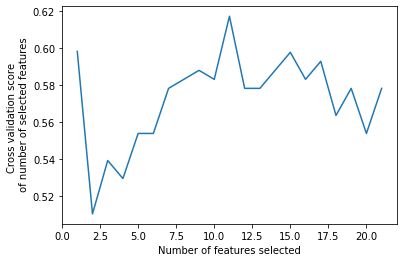

The optimal number of features is 11
The selected features are:
['min', 'prctile95', 'std', 'MTD', 'skewness', 'Diff_mean_of_row', 'Diff_std_of_row', 'median_first_ring', 'median_core', 'CWSI', 'CWSI_minus_CWSI_of_row']
Column: 0, Selected True, Rank: 1.000
Column: 1, Selected False, Rank: 5.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 9.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected False, Rank: 10.000
Column: 8, Selected False, Rank: 8.000
Column: 9, Selected False, Rank: 11.000
Column: 10, Selected False, Rank: 7.000
Column: 11, Selected False, Rank: 4.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected False, Rank: 6.000
Column: 15, Selected True, Rank: 1.000
Column: 16, Selected False, Rank: 3.000
Column: 17, Selected False, Rank: 2.000
Column: 18, Selected True, Rank: 1.000
Column: 19, Selected True, Rank: 1.00

In [39]:
random.seed(10)
features = RFECV_Random_Forest(data_train.drop(vars_to_drop,axis=1),data_labels_train.ravel())

In [50]:
features=['min', 'prctile95', 'std', 'MTD', 'skewness', 'Diff_mean_of_row', 'Diff_std_of_row', 'median_first_ring', 'median_core', 'CWSI', 'CWSI_minus_CWSI_of_row']

In [51]:
data_train[features]
data_labels_train =data_labels_train['Type']

In [52]:
ml_results,best_models,metrics_results = conduct_tunning_and_classification_for_each_family_model_CV(data_train[features],
                                                                                                     data_labels_train,
                                                                                                     stage='')

DecisionTree
DT _results_summary was created
RandomForest
RF _results_summary was created
NaiveBayes
Naive Bayes _results_summary was created
KNN
KNN _results_summary was created
svm_linear
svm_linear _results_summary was created
svm_rbf
svm_rbf _results_summary was created
svm_poly


C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Cons

C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Cons

C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Cons

C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


svm_poly _results_summary was created


In [53]:
best_models#.sort_values(by=[metric_to_optimize],ascending=False )

Algorithm,DT,RF,Naive Bayes,KNN,svm_linear,svm_rbf,svm_poly
model_index,17,28,1,45,1,28,17
MCC,0.471292,0.46543,0.353021,0.465328,0.302345,0.538501,0.521565
ACC,0.731707,0.722561,0.674797,0.723577,0.609756,0.768293,0.756606
F1score,0.731707,0.721616,0.692202,0.711942,0.733333,0.78614,0.766965
F2score,0.700935,0.680369,0.678536,0.666894,0.873016,0.784228,0.743543
FNR,0.31818,0.34321,0.32938,0.35968,0.0,0.21577,0.2702
FPR,0.21053,0.19688,0.31774,0.17739,0.84211,0.24987,0.20955
FNR_Leak,0.31818,0.34321,0.32938,0.35968,0.0,0.21577,0.2702
FNR_Clog,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FPR_Leak,0.21053,0.19688,0.31774,0.17739,0.84211,0.24987,0.20955


## Evaluating model performence on independent data set (Lavi)

In [62]:
test_set  = df_Lavi_Kedma[df_Lavi_Kedma.Site_Name=='Kedma'].copy(True)

In [63]:
data_labels_test['Type']= test_set['Type'].astype('category').copy(True)
data_test = test_set[features]
data_labels_test['Type']

204    Control
205       Leak
206    Control
207       Leak
208    Control
        ...   
388       Leak
389       Leak
390       Leak
391       Leak
392       Leak
Name: Type, Length: 189, dtype: category
Categories (3, object): ['Clog', 'Control', 'Leak']

In [120]:
results = init_metrics()
Algorithm='SVM rbf'
params = {
          "kernel": "rbf",
          "c": 0.1,
          "gamma": 0.001
        }
    
classifier=svm.SVC(probability=True,kernel=params['kernel'],C=params['c'],gamma=params['gamma'],max_iter=100000)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(data_train)
x_test= scaler.fit_transform(data_test)

classifier.fit(x_train, data_labels_train.values.ravel())
y_prediction = classifier.predict(x_test)

results = calculate_metrics(Algorithm,data_labels_test,y_prediction,results)

results_summary = pd.DataFrame([[Algorithm,*list(params.values()),
                                      results['FNR'][Algorithm], results['FPR'][Algorithm],
                                     results['MCC'][Algorithm], results['ACC'][Algorithm],
                                     results['F1score'][Algorithm], results['F2score'][Algorithm]]],
            columns=['Algorithm',*list(params.keys()),'FNR','FPR', 'MCC', 'ACC','F1score','F2score'])

results_summary

ValueError: could not convert string to float: 'B'

# Y as ordinary

In [64]:
Y_Ordinary = pd.DataFrame(data_labels_train).copy(True)
Y_Ordinary
Y_Ordinary['Y'] = 0 
Y_Ordinary.loc[Y_Ordinary['Type'] == 'Clog', 'Y'] = 0
Y_Ordinary.loc[Y_Ordinary['Type'] == 'Control', 'Y'] = 1
Y_Ordinary.loc[Y_Ordinary['Type'] == 'Leak', 'Y'] = 2

Y_Ordinary_new= pd.Series(Y_Ordinary['Type'], dtype="category")
Y_Ordinary_new= Y_Ordinary_new.cat.codes
X=data_train.drop(vars_to_drop,axis=1)
y=Y_Ordinary_new


In [60]:
import random
random.seed(10)
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import matthews_corrcoef
import sklearn.metrics as m
import mord as mor

from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

average='weighted'
# Automatically select the number of features for RFE
# create pipeline
rfe = RFECV(estimator= mor.LogisticIT())

model =mor.LogisticIT()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=5, random_state=12)

n_scores = cross_val_score(pipeline, X, y, scoring=ftwo_scorer, cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
rfe.fit(X, y)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score \n of number of selected features")
plt.plot(range(1, len(rfe.grid_scores_)+1), rfe.grid_scores_)
plt.show()

print('The optimal number of features is {}'.format(rfe.n_features_))
features2 = [f for f,s in zip(X.columns, rfe.support_) if s]
print('The selected features are:')
print ('{}'.format(features2))

for i in range(X.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))


KeyboardInterrupt: 

In [65]:
features2 = ['min', 'prctile5', 'prctile95', 'skewness', 'IQR', 'Diff_std_of_plot', 'Diff_std_of_row', 'CWSI']
data_train2=data_train[features2].copy(True)
data_train2

,min,prctile5,prctile95,skewness,IQR,Diff_std_of_plot,Diff_std_of_row,CWSI
0,1.996309,2.153483,4.016075,0.470617,0.951025,0.485750,0.558871,0.441409
1,1.538782,1.772915,3.963276,0.440120,0.966451,0.419287,0.629056,0.388723
2,0.913867,1.444201,9.122904,0.949360,2.865034,0.217501,0.274137,0.483383
3,0.906741,1.396416,3.784276,-0.129647,0.865771,0.395007,0.451857,0.352033
4,0.328303,0.904119,8.585528,0.789978,2.877661,0.282556,0.219605,0.441528
...,...,...,...,...,...,...,...,...
199,-2.113340,-1.249887,3.226028,0.557467,1.988691,-0.302097,-0.268991,-0.210420
200,-0.870867,-0.405574,7.371868,1.425781,2.436094,0.166306,0.051761,0.101833
201,-2.100496,-1.654684,7.882079,1.544537,2.875854,-0.369330,-0.432281,-0.105052
202,-1.611565,-1.032817,7.463001,1.459241,2.969077,-0.116032,-0.146433,-0.052087


In [66]:
ml_results,best_models,metrics_results = conduct_tunning_and_classification_for_each_family_model_CV(data_train2,
                                                                                                     data_labels_train,
                                                                                                     stage='\\Features_of_Y_as_ordinary')

DecisionTree
DT _results_summary was created
RandomForest
RF _results_summary was created
NaiveBayes
Naive Bayes _results_summary was created
KNN
KNN _results_summary was created
svm_linear
svm_linear _results_summary was created
svm_rbf
svm_rbf _results_summary was created
svm_poly


C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Cons

C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Cons

C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Cons

C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Cons

C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Cons

C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Cons

C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Cons

C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Cons

C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Cons

C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\noy\Anaconda3\envs\seaversioneleven\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Cons

svm_poly _results_summary was created


In [67]:
best_models#.sort_values(by=['F2score'],ascending=False )

Algorithm,DT,RF,Naive Bayes,KNN,svm_linear,svm_rbf,svm_poly
model_index,20,14,1,57,3,19,54
MCC,0.417662,0.422269,0.356268,0.359421,0.413921,0.385615,0.398403
ACC,0.707317,0.689837,0.674797,0.634146,0.658537,0.682927,0.674797
F1score,0.714286,0.66963,0.68939,0.540984,0.5625,0.677839,0.643326
F2score,0.694444,0.608734,0.668196,0.445841,0.459184,0.635919,0.574786
FNR,0.31818,0.42457,0.34453,0.60079,0.59091,0.38867,0.46245
FPR,0.26316,0.16959,0.29922,0.07968,0.05263,0.22904,0.15789
FNR_Leak,0.31818,0.42457,0.34453,0.60079,0.59091,0.38867,0.46245
FNR_Clog,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FPR_Leak,0.26316,0.16959,0.29922,0.07968,0.05263,0.22904,0.15789


## Evaluating model performence on independent data set (Lavi)

In [65]:
data_test2=test_set[features2].copy(True)
data_test2.head(5)

,MTD,Meanci_1,Diff_median_of_plot,Diff_mean_of_row,Diff_std_of_row,median_second_ring,CWSI,CWSI_minus_CWSI_of_row
0,1.857778,3.180862,-1.293726,-1.275677,0.687112,2.991489,0.537787,-0.320373
1,9.267117,4.857138,-1.413829,-1.292092,0.497600,3.774675,0.617892,-0.234274
2,2.295044,2.880736,-0.966367,-0.964791,0.558871,2.636387,0.441409,-0.223995
3,2.695513,2.661326,-0.702693,-0.979400,0.629056,2.423534,0.388723,-0.213326
4,10.044307,4.111615,-0.962213,-1.359424,0.274137,3.275674,0.483383,-0.210300


In [ ]:
results2 = init_metrics()
{'kernel': 'rbf', 'C': 100, 'gamma': 0.1}

Algorithm='SVM rbf'
params = {
          "kernel": "rbf",
          "c": 0.1,
          "gamma": 0.001
        }
    
classifier=svm.SVC(probability=True,kernel=params['kernel'],C=params['c'],gamma=params['gamma'],max_iter=100000)

scaler = MinMaxScaler()
x_train2 = scaler.fit_transform(data_train2)
x_test2= scaler.fit_transform(data_test2)

classifier.fit(x_train2,data_labels_train2.values.ravel())
y_prediction2 = classifier.predict(x_test2)

results2 = calculate_metrics(Algorithm,data_labels_test2,y_prediction2,results2)

results_summary = pd.DataFrame([[Algorithm,*list(params.values()),
                                      results2['FNR'][Algorithm], results2['FPR'][Algorithm],
                                     results2['MCC'][Algorithm], results2['ACC'][Algorithm],
                                     results2['F1score'][Algorithm], results2['F2score'][Algorithm]]],
            columns=['Algorithm',*list(params.keys()),'FNR','FPR', 'MCC', 'ACC','F1score','F2score'])

results_summary